<a href="https://colab.research.google.com/github/bharathsanjai/hand-gesture-recognition/blob/main/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Running on GPU

import platform
import tensorflow as tf

print("Python version: ", platform.python_version())
print("TensorFlow version: ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Running on CPU.')
else:
    print('GPU found. Running on GPU.')

Python version:  3.10.12
TensorFlow version:  2.12.0
GPU found. Running on GPU.


In [2]:
!pip install imageio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage.transform import resize
from imageio import imread
import imageio
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
batch_size = 10 # experiment with the batch size

In [19]:
# np.random.seed(5)
# random_numbers = np.random.randint(0, 30, size=18)
# random_numbers

array([ 3, 14, 15, 29,  6, 22, 16,  9,  8,  4,  7, 27, 16, 16,  7, 12, 15,
       17])

In [20]:
# samples_per_folder = 18

# def batchsize(folder_list):
#   result = math.ceil(folder_list.length *  samples_per_folder / batch_size)
#   print('result is =', result)

In [21]:
# batch_size = 10 # experiment with the batch size
# selecting alternate frames
# seq_idx =  np.round(np.linspace(0, 29, 20)).astype(int)
# image dimensions
# dim_x, dim_y = 120, 120

In [7]:
def cropResize(image, y, z):
    h, w = image.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [8]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]


In [9]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [10]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [11]:
def genhelper(source_path, folder_list, batch_size, img_tensor, t, batch):
  [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
  # img_idx = [1,4,5,6,7,9,21]
  # print('IMG tensor ...', img_tensor[0])
  img_idx = img_tensor[0]
  # print('IMG DX list', img_idx)
  batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                # print(' Foder currently reading : ='+ source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                # print('IMGS...', imgs)

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # print('image index count : = ', idx , ' ; item =', item)
                    # print('Batch: = ', batch , ' ; Batch size: =', batch_size , ' ; index =' , batch*batch_size)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # print('folder list length = ', folder_list)
    # [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    # img_idx = img_tensor[0]

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        print('; Num of batches =', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            print('; Current Batch =', batch)
            yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
          batch_size = len(folder_list)%batch_size
          yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [14]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [13]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, 32, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  /content/drive/My Drive/Project_data/train ; batch size = 32
; Num of batches = 20
; Current Batch = 0
IMG tensor 0 [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
IMG DX list [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
IMGS... ['WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00049.png', 'WIN_20180926_17_24_58_Pro_00051.png', 'WIN_20180926_17_24_58_Pro_00047.png', 'WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00021.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00039.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00045.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00059.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58

<ipython-input-10-37d2658fef7f>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


IMGS... ['WIN_20180926_17_35_17_Pro_00060.png', 'WIN_20180926_17_35_17_Pro_00022.png', 'WIN_20180926_17_35_17_Pro_00038.png', 'WIN_20180926_17_35_17_Pro_00020.png', 'WIN_20180926_17_35_17_Pro_00026.png', 'WIN_20180926_17_35_17_Pro_00028.png', 'WIN_20180926_17_35_17_Pro_00058.png', 'WIN_20180926_17_35_17_Pro_00034.png', 'WIN_20180926_17_35_17_Pro_00042.png', 'WIN_20180926_17_35_17_Pro_00050.png', 'WIN_20180926_17_35_17_Pro_00056.png', 'WIN_20180926_17_35_17_Pro_00014.png', 'WIN_20180926_17_35_17_Pro_00018.png', 'WIN_20180926_17_35_17_Pro_00030.png', 'WIN_20180926_17_35_17_Pro_00040.png', 'WIN_20180926_17_35_17_Pro_00010.png', 'WIN_20180926_17_35_17_Pro_00006.png', 'WIN_20180926_17_35_17_Pro_00024.png', 'WIN_20180926_17_35_17_Pro_00048.png', 'WIN_20180926_17_35_17_Pro_00062.png', 'WIN_20180926_17_35_17_Pro_00016.png', 'WIN_20180926_17_35_17_Pro_00052.png', 'WIN_20180926_17_35_17_Pro_00008.png', 'WIN_20180926_17_35_17_Pro_00044.png', 'WIN_20180926_17_35_17_Pro_00004.png', 'WIN_20180926_17

In [14]:
# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/drive/My Drive/Project_data/val ; batch size = 10
; Num of batches = 10
; Current Batch = 0
IMG tensor 0 [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
IMG DX list [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
IMGS... ['WIN_20180907_15_57_43_Pro_00017.png', 'WIN_20180907_15_57_43_Pro_00031.png', 'WIN_20180907_15_57_43_Pro_00023.png', 'WIN_20180907_15_57_43_Pro_00021.png', 'WIN_20180907_15_57_43_Pro_00025.png', 'WIN_20180907_15_57_43_Pro_00029.png', 'WIN_20180907_15_57_43_Pro_00033.png', 'WIN_20180907_15_57_43_Pro_00015.png', 'WIN_20180907_15_57_43_Pro_00019.png', 'WIN_20180907_15_57_43_Pro_00013.png', 'WIN_20180907_15_57_43_Pro_00011.png', 'WIN_20180907_15_57_43_Pro_00009.png', 'WIN_20180907_15_57_43_Pro_00027.png', 'WIN_20180907_15_57_43_Pro_00055.png', 'WIN_20180907_15_57_43_Pro_00049.png', 'WIN_20180907_15_57_43_Pro_00057.png', 'WIN_20180907_15_57_43_Pro_00047.png', 'WIN_20180907_15_57_43_Pro_00043.png', 'WIN_20180907_15_57_43_P

<ipython-input-10-37d2658fef7f>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


IMGS... ['WIN_20180925_17_43_01_Pro_00030.png', 'WIN_20180925_17_43_01_Pro_00026.png', 'WIN_20180925_17_43_01_Pro_00011.png', 'WIN_20180925_17_43_01_Pro_00010.png', 'WIN_20180925_17_43_01_Pro_00029.png', 'WIN_20180925_17_43_01_Pro_00028.png', 'WIN_20180925_17_43_01_Pro_00034.png', 'WIN_20180925_17_43_01_Pro_00019.png', 'WIN_20180925_17_43_01_Pro_00024.png', 'WIN_20180925_17_43_01_Pro_00012.png', 'WIN_20180925_17_43_01_Pro_00008.png', 'WIN_20180925_17_43_01_Pro_00015.png', 'WIN_20180925_17_43_01_Pro_00031.png', 'WIN_20180925_17_43_01_Pro_00018.png', 'WIN_20180925_17_43_01_Pro_00021.png', 'WIN_20180925_17_43_01_Pro_00020.png', 'WIN_20180925_17_43_01_Pro_00022.png', 'WIN_20180925_17_43_01_Pro_00016.png', 'WIN_20180925_17_43_01_Pro_00009.png', 'WIN_20180925_17_43_01_Pro_00032.png', 'WIN_20180925_17_43_01_Pro_00033.png', 'WIN_20180925_17_43_01_Pro_00036.png', 'WIN_20180925_17_43_01_Pro_00007.png', 'WIN_20180925_17_43_01_Pro_00023.png', 'WIN_20180925_17_43_01_Pro_00017.png', 'WIN_20180925_17

In [15]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

print(make2dFilter(5))

(5, 5)


In [16]:
 inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
 print(inputShape)

(20, 120, 120, 3)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# #write your model here

# # Create a Sequential model
# model = Sequential()

# # Add Conv3D layer
# model.add(Conv3D(filters=16, kernel_size=(5, 5, 5), activation='relu', input_shape=(inputShape)))

# # Add Conv3D layer
# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))

# # Add Conv3D layer
# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))

# # Add MaxPooling3D layer
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # Add Flatten layer
# model.add(Flatten())

# # Add Dense layers
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='softmax'))  # num_classes is the number of classes in your problem

# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# optimiser = 'adam'
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

In [19]:
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 58, 58, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 58, 58, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 32)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
num_epochs = 25

In [29]:
import matplotlib.pyplot as plt

In [26]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-32-11e90372dca3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-11-9e653c9fc82e>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


; Current Batch = 135
Epoch 1/25
; Current Batch = 136
67/67 [==============================] - ETA: 0s - loss: 1.9583 - categorical_accuracy: 0.2289; Current Batch = 3
; Current Batch = 4
; Current Batch = 5
; Current Batch = 6
; Current Batch = 7
; Current Batch = 8
; Current Batch = 9
; Num of batches = 10
; Current Batch = 0
; Current Batch = 1
; Current Batch = 2
; Current Batch = 3

Epoch 1: saving model to model_init_2023-08-3109_43_59.510610/model-00001-1.95834-0.22886-4.47054-0.28000.h5
67/67 [==============================] - 59s 889ms/step - loss: 1.9583 - categorical_accuracy: 0.2289 - val_loss: 4.4705 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
; Current Batch = 203
18/67 [=======>......................] - ETA: 26s - loss: 2.2416 - categorical_accuracy: 0.0926; Num of batches = 221
; Current Batch = 0
67/67 [==============================] - ETA: 0s - loss: 1.9000 - categorical_accuracy: 0.2189; Current Batch = 4
; Current Batch = 5
; Current Batch = 6
; Cur

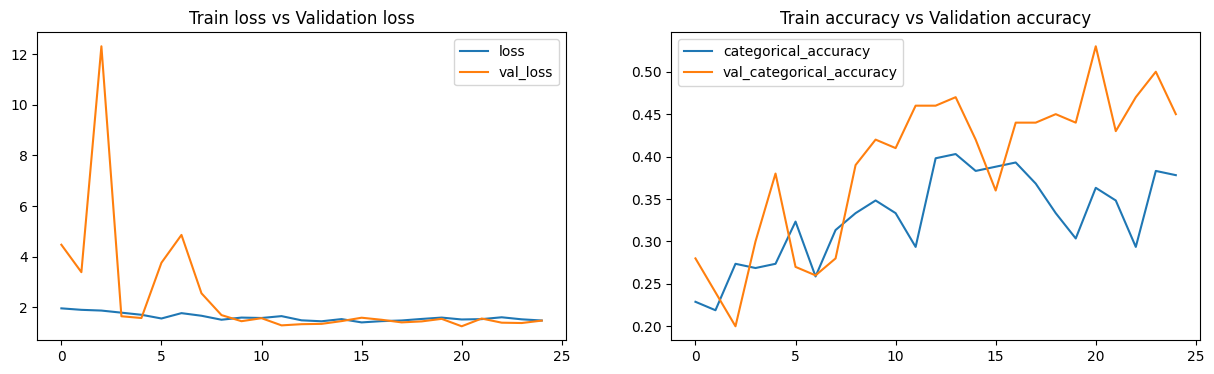

Max. Training Accuracy 0.4029850661754608
Max. Validaiton Accuracy 0.5299999713897705


In [33]:
plotModelHistory(base_model_history)